In [164]:
import pandas as pd 
ruleBasedParsing = pd.read_csv("VLM_responses_Baseline_SemanticParser.csv")
ruleBasedParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,SemanticParser
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions..."
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera..."
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions..."
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user', 'interactions': ['Sa..."


In [165]:
seq2seqParsing = pd.read_csv("Seq2SeqParsingOutput.csv")
seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions..."
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera..."
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions..."
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact..."


In [166]:
dependencyParsing = pd.read_csv("VLM_responses_Baseline_DependencyParser.csv")
dependencyParsing.head()

,UserPrompt,AssistantResponse,JSON,DependencyParser
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...","{'task': 'complete this task', 'interactions':..."
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...","{'task': 'change the contact name to Jane', 'i..."
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...","{'task': None, 'interactions': ['Submit', 'mic..."
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...","{'task': ""complete the task of ' Can I maintai..."
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...","{'task': ""save the user 's location"", 'interac..."


In [167]:
seq2seqParsing["RuleBasedParsing"] = ruleBasedParsing["SemanticParser"]
seq2seqParsing["DependencyParsing"] = dependencyParsing["DependencyParser"]
seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':..."
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i..."
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic..."
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai..."
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac..."


In [168]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast

# Assuming df is your DataFrame
# If JSON and Seq2SeqParser are dictionaries (or strings of dicts), convert them to string
def preprocess_cell(cell):
    if isinstance(cell, dict):
        return str(cell)
    try:
        # Try parsing if it's a string version of a dict
        return str(ast.literal_eval(cell))
    except:
        return str(cell)

seq2seqParsing['JSON_str'] = seq2seqParsing['JSON'].apply(preprocess_cell)
seq2seqParsing['Seq2Seq_str'] = seq2seqParsing['Seq2SeqParser'].apply(preprocess_cell)

# Compute cosine similarity using TF-IDF
vectorizer = TfidfVectorizer()
all_texts = seq2seqParsing['JSON_str'].tolist() + seq2seqParsing['Seq2Seq_str'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Split back into two matrices
json_tfidf = tfidf_matrix[:len(seq2seqParsing)]
seq2seq_tfidf = tfidf_matrix[len(seq2seqParsing):]

# Compute pairwise cosine similarity
similarities = cosine_similarity(json_tfidf, seq2seq_tfidf)

# Diagonal gives the similarity of each pair (JSON vs Seq2Seq in same row)
seq2seqParsing['JSON_Seq2Seq_Similarity'] = [similarities[i, i] for i in range(len(seq2seqParsing))]

# Display results
print(seq2seqParsing[['JSON', 'Seq2SeqParser', 'JSON_Seq2Seq_Similarity']])

seq2seqParsing.head()


                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885


In [169]:
seq2seqParsing['RuleBasedParsing_str'] = seq2seqParsing['RuleBasedParsing'].apply(preprocess_cell)

# Compute cosine similarity using TF-IDF
vectorizer = TfidfVectorizer()
all_texts = seq2seqParsing['JSON_str'].tolist() + seq2seqParsing['RuleBasedParsing_str'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Split back into two matrices
json_tfidf = tfidf_matrix[:len(seq2seqParsing)]
seq2seq_tfidf = tfidf_matrix[len(seq2seqParsing):]

# Compute pairwise cosine similarity
similarities = cosine_similarity(json_tfidf, seq2seq_tfidf)

# Diagonal gives the similarity of each pair (JSON vs Seq2Seq in same row)
seq2seqParsing['JSON_RuleBased_Similarity'] = [similarities[i, i] for i in range(len(seq2seqParsing))]

# Display results
print(seq2seqParsing[['JSON', 'Seq2SeqParser', 'JSON_RuleBased_Similarity']])

seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062


In [170]:
seq2seqParsing['DependencyParsing_str'] = seq2seqParsing['DependencyParsing'].apply(preprocess_cell)

# Compute cosine similarity using TF-IDF
vectorizer = TfidfVectorizer()
all_texts = seq2seqParsing['JSON_str'].tolist() + seq2seqParsing['DependencyParsing_str'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Split back into two matrices
json_tfidf = tfidf_matrix[:len(seq2seqParsing)]
seq2seq_tfidf = tfidf_matrix[len(seq2seqParsing):]

# Compute pairwise cosine similarity
similarities = cosine_similarity(json_tfidf, seq2seq_tfidf)

# Diagonal gives the similarity of each pair (JSON vs Seq2Seq in same row)
seq2seqParsing['JSON_Dependency_Similarity'] = [similarities[i, i] for i in range(len(seq2seqParsing))]

# Display results
print(seq2seqParsing[['JSON', 'Seq2SeqParser', 'JSON_Dependency_Similarity']])

seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,DependencyParsing_str,JSON_Dependency_Similarity
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'complete this task', 'interactions':...",0.654346
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990,"{'task': 'change the contact name to Jane', 'i...",0.761024
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367,"{'task': None, 'interactions': ['Submit', 'mic...",0.681054
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483,"{'task': ""complete the task of ' Can I maintai...",0.903219
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,"{'task': ""save the user 's location"", 'interac...",0.948752


In [171]:
%pip install sentence-transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [172]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import ast

# Load a BERT model optimized for sentence similarity
model = SentenceTransformer('all-distilroberta-v1')

In [173]:
# Generate embeddings
json_embeddings = model.encode(seq2seqParsing['JSON_str'].tolist(), convert_to_tensor=True)
seq2seq_embeddings = model.encode(seq2seqParsing['Seq2Seq_str'].tolist(), convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(json_embeddings, seq2seq_embeddings)

# Extract diagonal similarities (i.e., row-wise comparisons)
seq2seqParsing['BERT_Similarity_seq2seq'] = [cosine_scores[i][i].item() for i in range(len(seq2seqParsing))]

# View results
print(seq2seqParsing[['JSON', 'Seq2SeqParser', 'BERT_Similarity_seq2seq']])
seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,DependencyParsing_str,JSON_Dependency_Similarity,BERT_Similarity_seq2seq
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'complete this task', 'interactions':...",0.654346,1.000000
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990,"{'task': 'change the contact name to Jane', 'i...",0.761024,0.851061
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367,"{'task': None, 'interactions': ['Submit', 'mic...",0.681054,0.913866
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483,"{'task': ""complete the task of ' Can I maintai...",0.903219,0.954310
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,"{'task': ""save the user 's location"", 'interac...",0.948752,0.976079


In [174]:
rulebased_embeddings = model.encode(seq2seqParsing['RuleBasedParsing_str'].tolist(), convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(json_embeddings, rulebased_embeddings)

# Extract diagonal similarities (i.e., row-wise comparisons)
seq2seqParsing['BERT_Similarity_rulebased'] = [cosine_scores[i][i].item() for i in range(len(seq2seqParsing))]

# View results
print(seq2seqParsing[['JSON', 'RuleBasedParsing', 'BERT_Similarity_rulebased']])
seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,DependencyParsing_str,JSON_Dependency_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'complete this task', 'interactions':...",0.654346,1.000000,0.998490
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990,"{'task': 'change the contact name to Jane', 'i...",0.761024,0.851061,0.856032
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367,"{'task': None, 'interactions': ['Submit', 'mic...",0.681054,0.913866,0.975239
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483,"{'task': ""complete the task of ' Can I maintai...",0.903219,0.954310,0.965098
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,"{'task': ""save the user 's location"", 'interac...",0.948752,0.976079,0.951816


In [175]:
dependencyParsing_embeddings = model.encode(seq2seqParsing['DependencyParsing_str'].tolist(), convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(json_embeddings, dependencyParsing_embeddings)

# Extract diagonal similarities (i.e., row-wise comparisons)
seq2seqParsing['BERT_Similarity_dependency'] = [cosine_scores[i][i].item() for i in range(len(seq2seqParsing))]

# View results
print(seq2seqParsing[['JSON', 'DependencyParsing', 'BERT_Similarity_dependency']])
seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,DependencyParsing_str,JSON_Dependency_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased,BERT_Similarity_dependency
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'complete this task', 'interactions':...",0.654346,1.000000,0.998490,0.870896
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990,"{'task': 'change the contact name to Jane', 'i...",0.761024,0.851061,0.856032,0.911506
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367,"{'task': None, 'interactions': ['Submit', 'mic...",0.681054,0.913866,0.975239,0.842106
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483,"{'task': ""complete the task of ' Can I maintai...",0.903219,0.954310,0.965098,0.959020
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,"{'task': ""save the user 's location"", 'interac...",0.948752,0.976079,0.951816,0.967871


In [176]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Normalize Scores
scaler = MinMaxScaler()
tfidf_similarity_scores_seq2seq = scaler.fit_transform(np.array(seq2seqParsing["JSON_Seq2Seq_Similarity"]).reshape(-1,1)).flatten()
bert_similarity_scores_seq2seq = scaler.fit_transform(np.array(seq2seqParsing["BERT_Similarity_seq2seq"]).reshape(-1, 1)).flatten()
# bert_scores_f1_seq2seq = scaler.fit_transform(np.array(seq2seqParsing["BERTScore_Seq2Seq_F1"]).reshape(-1, 1)).flatten()



overall_similarity_scores_seq2seq = (
    0.2 * tfidf_similarity_scores_seq2seq +
    0.8 * bert_similarity_scores_seq2seq 
)

seq2seqParsing['Overall Similarity Seq2Seq'] = overall_similarity_scores_seq2seq

seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,DependencyParsing_str,JSON_Dependency_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased,BERT_Similarity_dependency,Overall Similarity Seq2Seq
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'complete this task', 'interactions':...",0.654346,1.000000,0.998490,0.870896,0.999999
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990,"{'task': 'change the contact name to Jane', 'i...",0.761024,0.851061,0.856032,0.911506,0.575214
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367,"{'task': None, 'interactions': ['Submit', 'mic...",0.681054,0.913866,0.975239,0.842106,0.705472
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483,"{'task': ""complete the task of ' Can I maintai...",0.903219,0.954310,0.965098,0.959020,0.823448
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,"{'task': ""save the user 's location"", 'interac...",0.948752,0.976079,0.951816,0.967871,0.930595


In [177]:

#Normalize Scores
scaler = MinMaxScaler()
tfidf_similarity_scores_ruleBased = scaler.fit_transform(np.array(seq2seqParsing["JSON_RuleBased_Similarity"]).reshape(-1,1)).flatten()
bert_similarity_scores_ruleBased = scaler.fit_transform(np.array(seq2seqParsing["BERT_Similarity_rulebased"]).reshape(-1, 1)).flatten()

overall_similarity_scores_ruleBased = (
    0.2 * tfidf_similarity_scores_ruleBased +
    0.8 * bert_similarity_scores_ruleBased
)

seq2seqParsing['Overall Similarity Rule Based'] = overall_similarity_scores_ruleBased

seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,DependencyParsing_str,JSON_Dependency_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased,BERT_Similarity_dependency,Overall Similarity Seq2Seq,Overall Similarity Rule Based
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'complete this task', 'interactions':...",0.654346,1.000000,0.998490,0.870896,0.999999,0.996567
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990,"{'task': 'change the contact name to Jane', 'i...",0.761024,0.851061,0.856032,0.911506,0.575214,0.627927
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367,"{'task': None, 'interactions': ['Submit', 'mic...",0.681054,0.913866,0.975239,0.842106,0.705472,0.886670
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483,"{'task': ""complete the task of ' Can I maintai...",0.903219,0.954310,0.965098,0.959020,0.823448,0.880302
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,"{'task': ""save the user 's location"", 'interac...",0.948752,0.976079,0.951816,0.967871,0.930595,0.867108


In [178]:

#Normalize Scores
scaler = MinMaxScaler()
tfidf_similarity_scores_dependency = scaler.fit_transform(np.array(seq2seqParsing["JSON_Dependency_Similarity"]).reshape(-1,1)).flatten()
bert_similarity_scores_dependency = scaler.fit_transform(np.array(seq2seqParsing["BERT_Similarity_dependency"]).reshape(-1, 1)).flatten()

overall_similarity_scores_ruleBased = (
    0.2 * tfidf_similarity_scores_dependency +
    0.8 * bert_similarity_scores_dependency
)

seq2seqParsing['Overall Similarity Dependency'] = overall_similarity_scores_ruleBased

seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,DependencyParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,DependencyParsing_str,JSON_Dependency_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased,BERT_Similarity_dependency,Overall Similarity Seq2Seq,Overall Similarity Rule Based,Overall Similarity Dependency
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...","{'task': 'complete this task', 'interactions':...","{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'view traffic updates', 'interactions...",1.000000,"{'task': 'complete this task', 'interactions':...",0.654346,1.000000,0.998490,0.870896,0.999999,0.996567,0.656234
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change the contact name to Jane', 'i...","{'task': 'change contact name to Jane Do', 'in...",{'task': 'change the contact name to Jane Do u...,0.703817,{'task': 'change the contact name to Jane Do u...,0.792990,"{'task': 'change the contact name to Jane', 'i...",0.761024,0.851061,0.856032,0.911506,0.575214,0.627927,0.763926
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera...","{'task': 'give their answer verbally', 'intera...","{'task': None, 'interactions': ['Submit', 'mic...","{'task': 'answer verbally and submit', 'intera...","{'task': 'give their answer verbally', 'intera...",0.640313,"{'task': 'give their answer verbally', 'intera...",0.736367,"{'task': None, 'interactions': ['Submit', 'mic...",0.681054,0.913866,0.975239,0.842106,0.705472,0.886670,0.601926
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': ""complete the task of ' Can I maintai...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.730867,"{'task': 'complete the task of', 'interactions...",0.813483,"{'task': ""complete the task of ' Can I maintai...",0.903219,0.954310,0.965098,0.959020,0.823448,0.880302,0.893667
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user's location', 'interact...","{'task': 'save the user', 'interactions': ['Sa...","{'task': ""save the user 's location"", 'interac...","{'task': 'save location', 'interactions': ['Fi...","{'task': 'save the user's location', 'interact...",0.947885,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,"{'task': ""save the user 's location"", 'interac...",0.948752,0.976079,0.951816,0.967871,0.930595,0.867108,0.921938


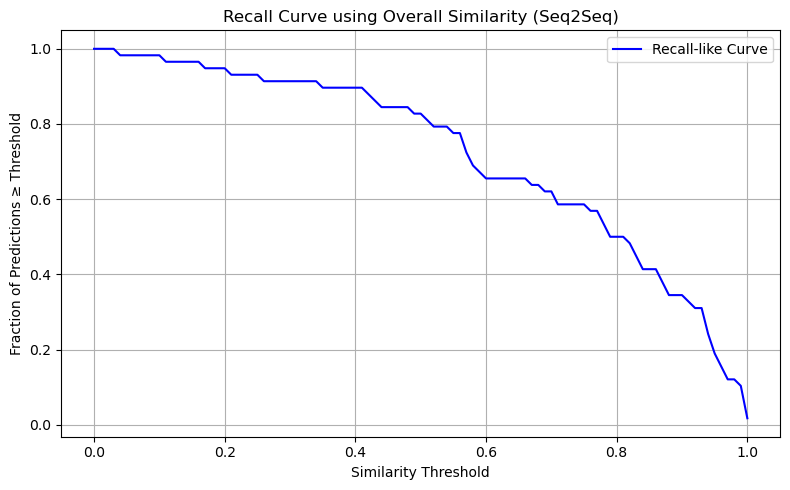

AUC: 0.7225


In [179]:
import numpy as np
import matplotlib.pyplot as plt


similarity_scores = seq2seqParsing['Overall Similarity Seq2Seq']

# thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []

for t in thresholds:
    passed = (similarity_scores >= t).sum()
    recalls.append(passed / len(similarity_scores))  # fraction of all examples

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label='Recall-like Curve', color='blue')
plt.xlabel('Similarity Threshold')
plt.ylabel('Fraction of Predictions ≥ Threshold')
plt.title('Recall Curve using Overall Similarity (Seq2Seq)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

auc = np.trapz(recalls, thresholds)
print(f"AUC: {auc:.4f}")


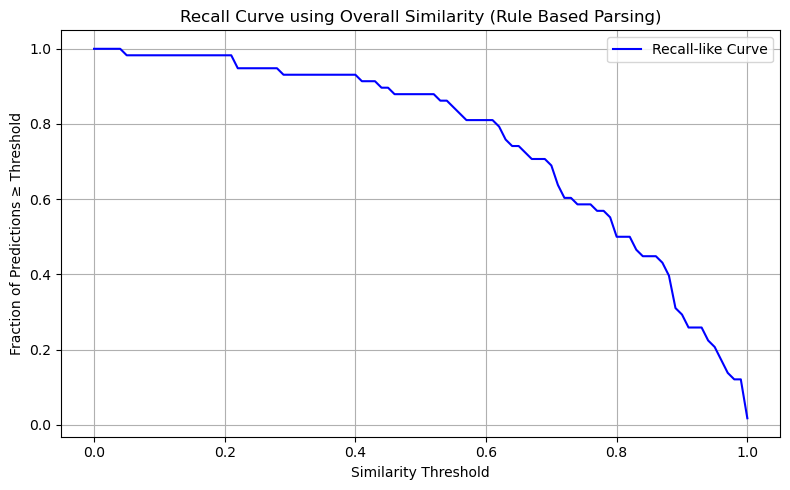

AUC: 0.7553


In [180]:
import numpy as np
import matplotlib.pyplot as plt


similarity_scores = seq2seqParsing['Overall Similarity Rule Based']

#thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []

for t in thresholds:
    passed = (similarity_scores >= t).sum()
    recalls.append(passed / len(similarity_scores))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label='Recall-like Curve', color='blue')
plt.xlabel('Similarity Threshold')
plt.ylabel('Fraction of Predictions ≥ Threshold')
plt.title('Recall Curve using Overall Similarity (Rule Based Parsing)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

auc = np.trapz(recalls, thresholds)
print(f"AUC: {auc:.4f}")


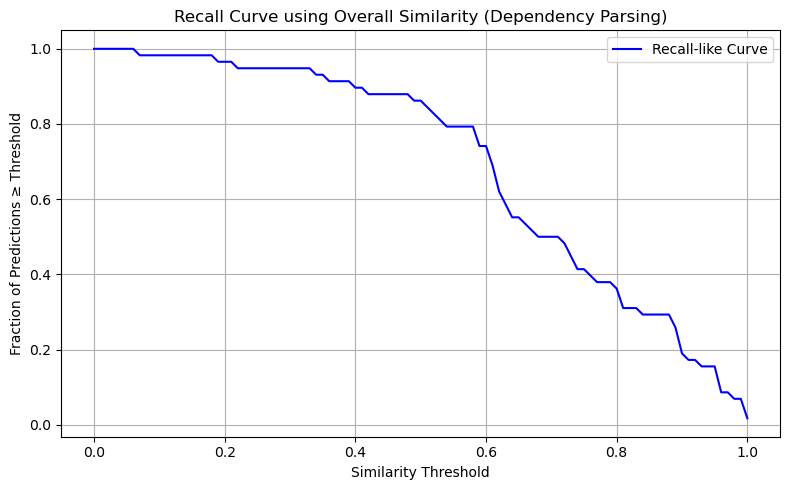

AUC: 0.6937


In [181]:
import numpy as np
import matplotlib.pyplot as plt

similarity_scores = seq2seqParsing['Overall Similarity Dependency']

#thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []

for t in thresholds:
    passed = (similarity_scores >= t).sum()
    recalls.append(passed / len(similarity_scores))  

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label='Recall-like Curve', color='blue')
plt.xlabel('Similarity Threshold')
plt.ylabel('Fraction of Predictions ≥ Threshold')
plt.title('Recall Curve using Overall Similarity (Dependency Parsing)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

auc = np.trapz(recalls, thresholds)
print(f"AUC: {auc:.4f}")

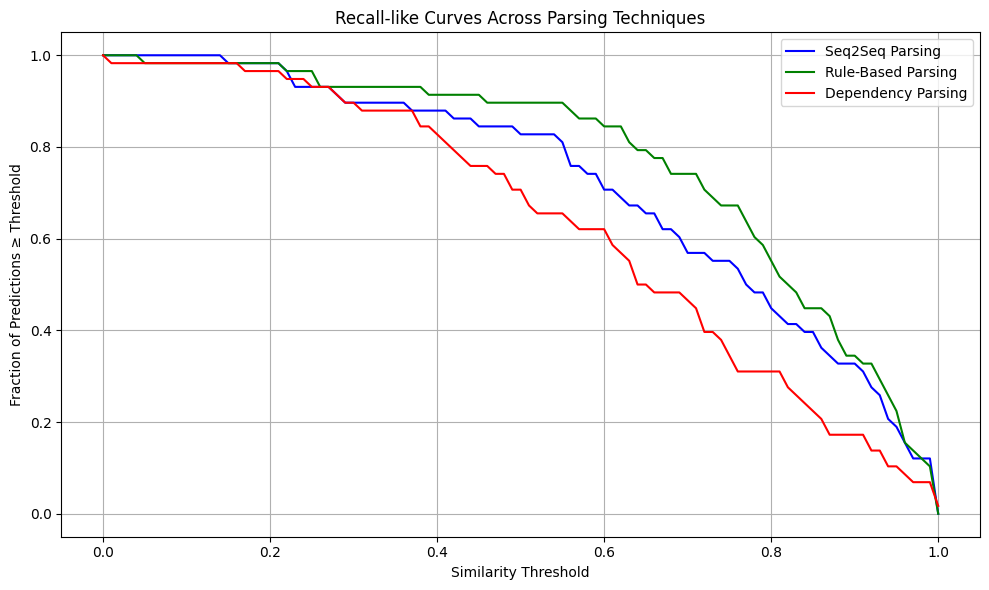

In [83]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)

# Store recall values for each method
methods = ['Overall Similarity Seq2Seq', 'Overall Similarity Rule Based', 'Overall Similarity Dependency']
labels = ['Seq2Seq Parsing', 'Rule-Based Parsing', 'Dependency Parsing']
colors = ['blue', 'green', 'red']
recall_curves = {}

for method in methods:
    similarity_scores = seq2seqParsing[method]
    recalls = [(similarity_scores >= t).sum() / len(similarity_scores) for t in thresholds]
    recall_curves[method] = recalls

# Plot all curves on the same graph
plt.figure(figsize=(10, 6))
for method, label, color in zip(methods, labels, colors):
    plt.plot(thresholds, recall_curves[method], label=label, color=color)

plt.xlabel('Similarity Threshold')
plt.ylabel('Fraction of Predictions ≥ Threshold')
plt.title('Recall-like Curves Across Parsing Techniques')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
